# Trabalho 4 - GMM

Aluno: Diego Freitas Holanda

Matricula: 411627

In [51]:
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.cluster import KMeans
%matplotlib inline

## Carregando dataset

In [2]:
dataset = np.genfromtxt('./clustering_data.csv', delimiter=',')

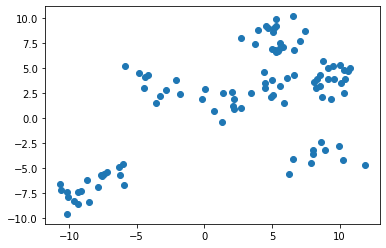

In [3]:
plt.scatter(dataset[:, 0], dataset[:, 1]);

## Implementação do GMM com MAP

In [43]:
class GMM:
    
    def __init__(self, K: int, pi: np.ndarray, mi: np.ndarray, cov: np.ndarray, alpha: np.ndarray, max_iter):
        self.K = K
        self.pi = pi
        self.mi = mi
        self.cov = cov
        self.alpha = alpha
        self.max_iter = max_iter
    
    def fit(self, X: np.ndarray):
        self._default_priors(X)
        
        N = len(X)
        self.r = np.empty((len(X), self.K))
        for t in range(self.max_iter):
            # Passo E
            normals = np.array([[self.pi[k]*self._normal(x, self.mi[k], self.cov[k]) for x in X] for k in range(self.K)])
            for k in range(self.K):
                self.r[:, k] = normals[k] / np.sum(normals, axis=0)
                            
            # Passo M
            x_hat = np.empty((self.K, X.shape[1]))
            sum_rk = np.sum(self.r, axis=0)
            D = X.shape[1]
            for k in range(self.K):
                
                self.pi[k] = (self.alpha[k] - 1 + sum_rk[k]) / (N - self.K + np.sum(self.alpha))
                
                x_hat[k] = self.r[:, [k]].T @ X / (sum_rk[k]+1e-10)
                self.mi[k] = ((self.k0 * self.mi0) + (x_hat[k] * sum_rk[k])) / (self.k0 + sum_rk[k])
                
                temp1 = ((self.k0 * sum_rk[k]) / (self.k0 + sum_rk[k])) * (x_hat[k] - self.mi0)**2
                temp2 = self.v0 + D + 2 + sum_rk[k]
                
                temp3 = np.sum([self.r[i, k]*((X[[i], :] - x_hat[k]).T@(X[[i], :] - x_hat[k])) for i in range(len(X))], axis=0)
                self.cov[k] = (self.S0 + temp3 + temp1) / temp2
    
    def predict(self, X: np.ndarray) -> np.ndarray:
        probs = np.array([[self._normal(x, self.mi[k], self.cov[k])for k in range(self.K)] for x in X])
        return np.argmax(probs, axis=1)
    
    def _default_priors(self, X: np.ndarray):
        self.S0 = (self.K**(-2/X.shape[1])) * np.cov(X, rowvar=False)
        self.v0 = X.shape[1] + 2
        self.mi0 = np.mean(X, axis=0)
        self.k0 = 0.01
    
    def _normal(self, x: np.ndarray, mi: np.ndarray, cov: np.ndarray) -> np.ndarray:
        N = len(x)
        
        temp1 = np.linalg.det(cov) ** (-1/2)
        temp2 = np.exp(-0.5 * (x - mi).T @ np.linalg.inv(cov) @ (x - mi))

        return (2 * np.pi) ** (-N/2) * temp1 * temp2

In [65]:
def create_and_fit_model(k):
    np.random.seed(24)
    dims = np.vstack([dataset.min(axis=0), dataset.max(axis=0)])
    
    pi0 = np.ones(k) / np.ones(k).sum()

    mi0 = (np.random.rand(k, dataset.shape[1]) * (dims[1] - dims[0])) + dims[0]

    cov0 = (np.random.rand(k, dataset.shape[1], dataset.shape[1])*10 + 1e-10) * np.eye(dataset.shape[1])

    alpha0 = np.ones(k)

    model = GMM(k, pi0, mi0, cov0, alpha0, 30)
    model.fit(dataset)
    return model

## Setup para o plot

In [27]:
size = 100

x = np.linspace(-20, 20, size)
y = np.linspace(-20, 20, size)

x1,x2 = np.meshgrid(x, y)
grid = np.vstack([x1.reshape(-1), x2.reshape(-1)]).T

In [64]:
def plot_normals(k, model, ax):
    normals = np.array([[model._normal(x, model.mi[i], model.cov[i]) for i in range(k)] for x in grid])
    grid_n = np.sum(normals / (normals.max(axis=0) + 1e-12), axis=1)
    y_predict = model.predict(dataset)
    ax.scatter(grid[:, 0], grid[:, 1], c=grid_n)
    cmap = cm.tab20.colors
    for i in range(k):
        n = len(dataset[:, 0][y_predict==i])
        ax.scatter(dataset[:, 0][y_predict==i], dataset[:, 1][y_predict==i], color=cmap[i], s=15, edgecolors='white', label=i+1);
        ax.scatter(model.mi[i,0], model.mi[i,1], color=cmap[i], marker='x', s=30);
        ax.legend();

## Resultados

In [66]:
list_of_k = [2, 4, 6, 8, 10]
models = [create_and_fit_model(k) for k in list_of_k]

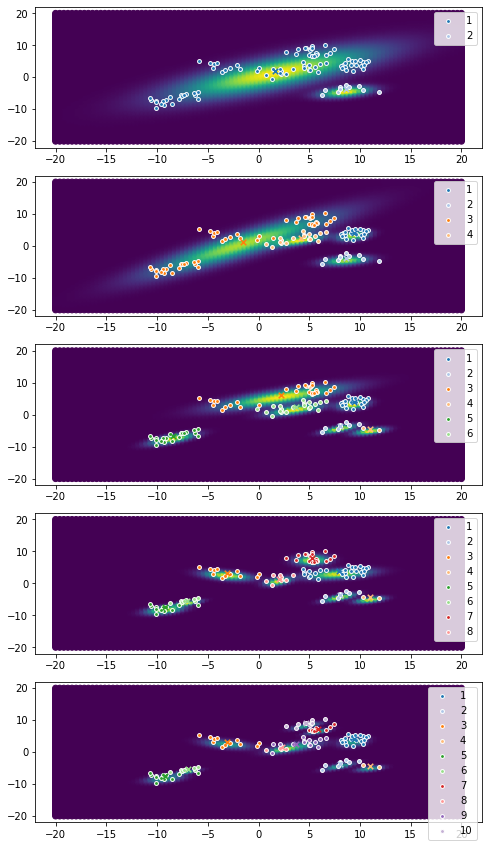

In [67]:
fig, ax = plt.subplots(figsize=(8, 15), nrows=5)
for k in range(len(list_of_k)):
    plot_normals(list_of_k[k], models[k], ax[k])